In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from random import random, randrange, choice, shuffle, randint
from datetime import datetime, timedelta, date
from pprint import pprint
import calendar

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [81]:
### Function #################################
import functools
def unpack_df_columns(func):
    @functools.wraps(func)
    def _unpack_df_columns(*args, **kwargs):
        series = args[0]
        return func(*series.values)
    return _unpack_df_columns

@unpack_df_columns
def 블록우선순위구하기(날짜순서, 공기순서, 크기순서):
    global 착수일가중치, 공기가중치, 크기가중치
    result = np.round((날짜순서*float(착수일가중치) + 공기순서*float(공기가중치) + 크기순서*float(크기가중치))/3,1)
    return result

@unpack_df_columns
def 블록사이즈튜플만들기(가로, 세로):
    길이2 = max(가로, 세로)  
    길이1 = min(가로, 세로)
    result = (길이2, 길이1)
    return result

def 블록종류구하기(스테이지):
    if 스테이지 in [41, 42]:
        return "대조립"
    else:
        return "중조립"

def 블록타입구하기(블록):
    return 블록[-1:]

@unpack_df_columns
def get_pair_id1(호선번호, 블록):
    result = str(호선번호)+블록[:-1]
    return result

@unpack_df_columns
def get_pair_id2(블록종류, 호선번호, 블록):
    result = str(블록종류)+str(호선번호)+블록[:-1]
    return result

@unpack_df_columns
def 계획공기구하기(블록종류, 표준공기):
    if 블록종류 == "대조립":
        대조립공기 = 7 + 5  #생산7, 반출5
        return min(대조립공기, 표준공기)
    else:
        중조립공기 = 6
        return min(중조립공기, 표준공기)

@unpack_df_columns
def 최소착수요구일구하기(납기, 공기):
    result = pd.to_datetime(납기) - timedelta(days=int(공기))
    return result.date()

def 최선조기착수일구하기(중_착수일):
    조기착수한계일수 = 9
    return pd.to_datetime(중_착수일) - timedelta(days=int(조기착수한계일수))
    
@unpack_df_columns
def E32C세로길이조정하기(블록, 세로):   # E32C 블록은 안전통로 일부 침범하여 세로 배치가능한 점 고려
    if 블록 == "E32C":
        return 세로 - 1
    else:
        return 세로
    
def 블록데이터전처리(블록원데이터):
    블록데이터 = 블록원데이터.copy()
    블록데이터["블록종류"] = 블록데이터["스테이지"].apply(블록종류구하기)
    블록데이터["타입"] = 블록데이터["블록"].apply(블록타입구하기)
    블록데이터["PAIR_ID1"] = 블록데이터[["호선번호", "블록"]].apply(get_pair_id1, axis=1)
    블록데이터["PAIR_ID2"] = 블록데이터[["블록종류","호선번호", "블록"]].apply(get_pair_id2, axis=1)

    블록데이터["가로"] = 블록데이터["가로"].apply(lambda x: np.round(x,0))
    블록데이터["세로"] = 블록데이터["세로"].apply(lambda x: np.round(x,0))
    블록데이터["세로"] = 블록데이터[["블록", "세로"]].apply(E32C세로길이조정하기, axis=1)
    블록데이터["사이즈"] = 블록데이터[["가로", "세로"]].apply(블록사이즈튜플만들기, axis=1)
    블록데이터["면적"] = 블록데이터.eval("가로*세로")
    블록데이터["최대길이"] = 블록데이터["사이즈"].apply(lambda x: max(x))
    블록데이터["최소길이"] = 블록데이터["사이즈"].apply(lambda x: min(x))
    
    블록데이터["중_완료일"] = pd.to_datetime(블록데이터["중_완료일"])
    블록데이터["계획공기"] = 블록데이터[["블록종류", "표준공기"]].apply(계획공기구하기, axis=1)
    블록데이터["최소착수요구일"] = 블록데이터[["중_완료일", "계획공기"]].apply(최소착수요구일구하기, axis=1)
    블록데이터["최선조기착수일"] = 블록데이터["중_착수일"].apply(최선조기착수일구하기)
    
    블록데이터["날짜순서"] = 블록데이터["최소착수요구일"].rank()
    블록데이터["공기순서"] = 블록데이터["표준공기"].rank(ascending=False)
    블록데이터["크기순서"] = 블록데이터["면적"].rank(ascending=False)
    블록데이터["우선순위"] = 블록데이터[["날짜순서", "공기순서", "크기순서"]].apply(블록우선순위구하기, axis=1)
    
    블록데이터 = 블록데이터.sort_values(by=["우선순위"])
    return 블록데이터

def get_pair_count1(SP_PAIR):
    global 블록데이터
    result = 블록데이터["PAIR_ID1"].value_counts()[SP_PAIR]
    return result

def get_pair_count2(SP_PAIR):
    global 블록데이터
    result = 블록데이터["PAIR_ID2"].value_counts()[SP_PAIR]
    return result

@unpack_df_columns
def 정반사이즈튜플만들기(가로, 세로):
    길이1 = max(가로, 세로)  
    길이2 = min(가로, 세로)   
    result = (길이1, 길이2)
    return result

def 정반데이터전처리(정반원데이터):
    df = 정반원데이터.copy()
    df["세로"] = df["세로"].apply(lambda x : x + 1) # 세로 길이 1m 추가 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1
    df["사이즈"] = df[["가로", "세로"]].apply(정반사이즈튜플만들기, axis=1)
    df["최대길이"] = df["사이즈"].apply(lambda x: max(x))
    df["최소길이"] = df["사이즈"].apply(lambda x: min(x))
    return df

def 반출한계사이즈체크(blk_id):  # 블록의 최소길이가 정반의 반출한계사이즈보다 작고
    가능정반리스트 = []
    블록최소길이 = 블록데이터[블록데이터["blk_id"]==blk_id]["최소길이"].values[0]
    for 정반명 in 정반데이터["정반명"]:
        반출한계사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["반출한계사이즈"].values[0]
        if 반출한계사이즈 > 블록최소길이:
            가능정반리스트.append(정반명)
    return 가능정반리스트

def 정반최대길이체크(blk_id, 정반리스트):  # 블록의 최대길이가 정반최대길이보다 작고
    가능정반리스트 = []
    블록최대길이 = 블록데이터[블록데이터["blk_id"]==blk_id]["최대길이"].values[0]
    for 정반명 in 정반리스트:
        정반최대길이 = 정반데이터[정반데이터["정반명"]==정반명]["최대길이"].values[0]
        if 정반최대길이 >= 블록최대길이:
            가능정반리스트.append(정반명)
    return 가능정반리스트

def 중조립블록_반출사이즈_체크(blk_id, 정반리스트):
    블록종류 = 블록데이터[블록데이터["blk_id"]==blk_id]["블록종류"].values[0]

    if 블록종류 == "중조립" and (("C1" in 정반리스트)or("C2" in 정반리스트)):
        블록사이즈 = 블록데이터[블록데이터["blk_id"]==blk_id]["사이즈"].values[0]
        작은길이, 큰길이 = min(블록사이즈), max(블록사이즈)
        if 작은길이 >= 13 or 큰길이 >= 15:
            for 정반 in ["C1", "C2"]:
                try:
                    정반리스트.remove(정반)
                except:
                    pass
    else:
        pass
    return 정반리스트

def 블록종류체크(blk_id, 정반리스트):   
    filtered_list = 정반리스트.copy()
    블록종류 = 블록데이터[블록데이터["blk_id"]==blk_id]["블록종류"].values[0]
    # 블록 = 블록데이터[블록데이터["blk_id"]==blk_id]["블록"].values[0]
    if 블록종류 == "대조립":
        filtered_list = [item for item in 정반리스트 if item not in ('C1', 'C2')]
    return filtered_list


def init_jungban(사이즈):  #사이즈 = (10, 10)
    surface_width, surface_height = 사이즈[0], 사이즈[1]  # Adjusted to match the provided image for demonstration
    surface = np.zeros((surface_height, surface_width), dtype=int)
    return surface, surface_width, surface_height

def can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
    new_width = int(surface_width - thresh)
    new_height = int(surface_height - thresh)
    if start_row + block_height > surface_height or start_col + block_width > surface_width:
        return False
    block_area = surface[int(start_row):int(start_row+block_height), int(start_col):int(start_col+block_width)]
    if np.any(block_area != 0):
        return False
    if start_row > 0 and np.any(surface[int(start_row-thresh): int(start_row),int(start_col):int(start_col+block_width)] != 0):
        return False
    if start_col > 0 and np.any(surface[int(start_row): int(start_row+block_height), int(start_col-thresh): int(start_col)] != 0):
        return False
    return True

# Function to place a block on the surface, if possible
def place_block(surface, block_height, block_width, start_row, start_col, block_id):
    block_height, block_width = block_height, block_width
    surface[int(start_row):int(start_row + block_height), int(start_col):int(start_col + block_width)] = block_id
    return surface

def 레이아웃배치(surface, surface_width, surface_height, block_height, block_width, block_id, thresh):
    best_fit_score = float('inf')
    best_position = None
    surface_height = int(surface_height)
    block_height = int(block_height)
    loop_num = int(surface_height - block_height + 1)
    
    for start_row in range(loop_num):
        for start_col in range(loop_num):
            if can_place_with_thresh(surface, surface_width, surface_height, block_height, block_width, start_row, start_col, thresh):
                # Calculate a score; here we use the top-left corner (y, x) as the score
                # A lower score means the block is closer to the top-left
                score = start_row + start_col
                if score < best_fit_score:
                    best_fit_score = score
                    best_position = (start_row, start_col)
    if best_position:
        surface = place_block(surface, block_height, block_width, *best_position, block_id)
        return True, surface
    else:
        return False, surface

def get_overlapped_surface(*arrays):
    result = arrays[0]
    for arr in arrays[1:]:
        result = np.add(result, arr)
    return result

# 특정 값만 남기고 다 지운후에 그 결과를 다시 각 해당일 surface에 더해준다...천재네..ㅋ
def extract_newblock_layout_only(overlapped_surface, block_id):
    mask = overlapped_surface != block_id
    overlapped_surface[mask] = 0
    newblock_layout = overlapped_surface
    return newblock_layout

def draw_layout(레이아웃달력, 정반, 날짜idx):
    target_date = 레이아웃달력.index[날짜idx]
    print(f"target_date: {target_date}")
    target_surface = 레이아웃달력.at[target_date, 정반]
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.imshow(target_surface, cmap="Blues", interpolation='nearest')
    for i in range(len(target_surface)):
        for j in range(len(target_surface[0])):
            plt.text(j, i, f'{target_surface[i, j]}', ha='center', va='center', color='white', fontsize=7)
    plt.show()
    return target_surface

def draw_layout_6_subplots(레이아웃달력, 정반리스트, idx):
    정반1 = 정반리스트[0]
    정반2 = 정반리스트[1]
    정반3 = 정반리스트[2]
    정반4 = 정반리스트[3]
    정반5 = 정반리스트[4]
    정반6 = 정반리스트[5]
    target_date = 레이아웃달력.index[idx]
    print(target_date)
    target_surface1 = 레이아웃달력.at[target_date, 정반1]
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(20, 15))
    cmap = mcolors.ListedColormap(['white'] + ['C{}'.format(i) for i in range(188)])
    norm = mcolors.BoundaryNorm(np.arange(0.5, 188 + 2), cmap.N)
    ax = axs[0]
    ax.imshow(target_surface1, cmap=cmap, interpolation='nearest')
    for i in range(len(target_surface1)):
        for j in range(len(target_surface1[0])):
            ax.text(j, i, f'{target_surface1[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반1}')  # Set subplot title
    target_surface2 = 레이아웃달력.at[target_date, 정반2]
    ax = axs[1]
    ax.imshow(target_surface2, cmap=cmap, norm=norm, interpolation='nearest')
    for i in range(len(target_surface2)):
        for j in range(len(target_surface2[0])):
            ax.text(j, i, f'{target_surface2[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반2}')  # Set subplot title
    target_surface3 = 레이아웃달력.at[target_date, 정반3]
    ax = axs[2]
    ax.imshow(target_surface3, cmap=cmap, norm=norm, interpolation='nearest')
    for i in range(len(target_surface3)):
        for j in range(len(target_surface3[0])):
            ax.text(j, i, f'{target_surface3[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반3}')  # Set subplot title
    target_surface4 = 레이아웃달력.at[target_date, 정반4]
    ax = axs[3]
    ax.imshow(target_surface4, cmap=cmap, norm=norm, interpolation='nearest')
    for i in range(len(target_surface4)):
        for j in range(len(target_surface4[0])):
            ax.text(j, i, f'{target_surface4[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반4}')  # Set subplot title
    target_surface5 = 레이아웃달력.at[target_date, 정반5]
    ax = axs[4]
    ax.imshow(target_surface5, cmap=cmap, norm=norm, interpolation='nearest')
    for i in range(len(target_surface5)):
        for j in range(len(target_surface5[0])):
            ax.text(j, i, f'{target_surface5[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반5}')  # Set subplot title
    target_surface6 = 레이아웃달력.at[target_date, 정반6]
    ax = axs[5]
    ax.imshow(target_surface6, cmap=cmap, interpolation='nearest')
    for i in range(len(target_surface6)):
        for j in range(len(target_surface6[0])):
            ax.text(j, i, f'{target_surface6[i, j]}', ha='center', va='center', color='white', fontsize=6)
    ax.set_title(f'{정반6}')  # Set subplot title
    plt.tight_layout()  # Adjust subplot layout
    plt.show()

def update_레이아웃달력_기배치블록(달력, 정반명, blk_id, 정반데이터, 블록데이터, 조기착수금지일, thresh):
    레이아웃달력 = 달력.copy()
    착수일 = 블록데이터[블록데이터["blk_id"]==blk_id]["실_착수일"].values[0]
    종료일 = 블록데이터[블록데이터["blk_id"]==blk_id]["실_완료일"].values[0]
    계획공기 = int(블록데이터[블록데이터["blk_id"]==blk_id]["계획공기"].values[0])
    블록사이즈 = 블록데이터[블록데이터["blk_id"]==blk_id]["사이즈"].values[0]
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    surface_width, surface_height = 정반사이즈[0], 정반사이즈[1]
    block_width, block_height = 블록사이즈[0], 블록사이즈[1]
    
    날짜리스트 = [d.strftime("%Y-%m-%d") for d in 레이아웃달력.index]
    start_date = 착수일 # datetime.strptime(최소착수요구일, "%Y-%m-%d").date()
    min_start_date = start_date
    end_date = 종료일
    min_start_date= np.datetime_as_string(min_start_date, unit='D') #min_start_date#.strftime('%Y-%m-%d')
    end_date = np.datetime_as_string(end_date, unit='D')#end_date#.strftime('%Y-%m-%d')
    min_start_idx = 날짜리스트.index(min_start_date)
    end_idx = 날짜리스트.index(end_date)
    

    for k in range(1):      
        target_surfaces = []
        temp_dates = []
        for idx in range(min_start_idx, end_idx+1): 
            target_date = 레이아웃달력.index[idx]    # 대상인덱스의 날짜 불러오기
            temp_dates.append(target_date)
            target_surface = 레이아웃달력.at[target_date, 정반명]  # 조회날짜의 레이아웃(서페이스) 불러오기
            target_surfaces.append(target_surface)   # 조회날짜의 레이아웃들을 리스트로 담기
                
        overlapped_surface = get_overlapped_surface(*target_surfaces)  # 리스트에 담은 레이아웃을 합하여 오버랩 레이아웃 생성
        bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)  # 오버랩 레이아웃에 신규 블록 레이아웃 배치검토
        if bool_res:  # 신규블록이 배치되어 True라면...
            newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
            for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                target_date = 레이아웃달력.index[idx]  
                target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
            최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
            최선정반 = 정반명
            break
        else:
            # 가로세로 바꿔서
            bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_height, block_width, blk_id, thresh)  
            if bool_res:
                newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
                for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                    target_date = 레이아웃달력.index[idx]  
                    target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                    target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                    레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
                최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
                최선정반 = 정반명
                break
            else:  # 신규블록 배치가 False라면.. 계속 순환
                최선배치일 = None
                최선정반 = None
    return 레이아웃달력, 최선정반, 최선배치일

def get_end_date_of_month(year, month):
    # Get the number of days in the given month
    num_days = calendar.monthrange(year, month)[1]
    # Return the last day of the month as a datetime object
    return date(year, month, num_days)

def create_레이아웃달력(시작년:int, 시작월:int, 시작일: int, 종료년:int, 종료월:int, 정반데이터:pd.DataFrame) -> pd.DataFrame:
    start_date = datetime(시작년, 시작월, 시작일)
    end_date = get_end_date_of_month(종료년, 종료월)
    정반집합 = 정반데이터["정반명"].tolist()
    날짜집합  = pd.date_range(start=start_date, end=end_date, freq='D')
    
    달력 = pd.DataFrame()
    달력.index = 날짜집합
    
    for 정반 in 정반집합:
        정반사이즈 = 정반데이터[정반데이터["정반명"]==정반]["사이즈"].values[0]
        # print(f"{정반}정반사이즈: {정반사이즈}")
        surface, surface_width, surface_height = init_jungban(정반사이즈)
        달력[정반] = [surface for _ in range(len(날짜집합))]
        
    return 달력

def update_레이아웃달력(달력, 정반명, blk_id, 정반데이터, 블록데이터, 조기착수금지일, thresh, 후퇴배수):
    레이아웃달력 = 달력.copy()
    최소착수요구일 = 블록데이터[블록데이터["blk_id"]==blk_id]["최소착수요구일"].values[0]
    최선조기착수일 = 블록데이터[블록데이터["blk_id"]==blk_id]["최선조기착수일"].values[0]

    계획공기 = int(블록데이터[블록데이터["blk_id"]==blk_id]["계획공기"].values[0])
    블록사이즈 = 블록데이터[블록데이터["blk_id"]==blk_id]["사이즈"].values[0]
    정반사이즈 = 정반데이터[정반데이터["정반명"]==정반명]["사이즈"].values[0]
    surface_width, surface_height = 정반사이즈[0], 정반사이즈[1]
    block_width, block_height = 블록사이즈[0], 블록사이즈[1]
    최선배치일 = ""
    
    날짜리스트 = [d.strftime("%Y-%m-%d") for d in 레이아웃달력.index]

    start_date = np.datetime_as_string(최선조기착수일, unit='D')
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_date = start_date.date()

    min_start_date = start_date #start_date - timedelta(days=0) 
    end_date = min_start_date + timedelta(days=계획공기)
    min_start_date= min_start_date.strftime('%Y-%m-%d')
    end_date = end_date.strftime('%Y-%m-%d')
    min_start_idx = 날짜리스트.index(min_start_date)
    end_idx = 날짜리스트.index(end_date)
    
    # 레이아웃 순환 검토 
    for k in range(후퇴배수):  
        # print(f">>>>> {정반명} {blk_id} - 검토차수{k} / {레이아웃달력.index[min_start_idx].strftime('%Y-%m-%d')}: 조회인덱스범위: {min_start_idx} ~ {end_idx}")
    
        target_surfaces = []
        temp_dates = []
        for idx in range(min_start_idx, end_idx+1): 
            target_date = 레이아웃달력.index[idx]    # 대상인덱스의 날짜 불러오기
            temp_dates.append(target_date)
            target_surface = 레이아웃달력.at[target_date, 정반명]  # 조회날짜의 레이아웃(서페이스) 불러오기
            target_surfaces.append(target_surface)   # 조회날짜의 레이아웃들을 리스트로 담기
                
        overlapped_surface = get_overlapped_surface(*target_surfaces)  # 리스트에 담은 레이아웃을 합하여 오버랩 레이아웃 생성
        bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_width, block_height, blk_id, thresh)  # 오버랩 레이아웃에 신규 블록 레이아웃 배치검토
        
        if bool_res:  # 신규블록이 배치되어 True라면...
            newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
            for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                target_date = 레이아웃달력.index[idx]  
                target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
            최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
            정반명 = 정반명
            return 레이아웃달력, 정반명, 최선배치일
            break

        else:
            # 가로세로 바꿔서
            bool_res, surface = 레이아웃배치(overlapped_surface, surface_width, surface_height, block_height, block_width, blk_id, thresh)  

            if bool_res:
                newblock_layout = extract_newblock_layout_only(surface, int(blk_id))  # 신규배치블록의 레이아웃만 추출 (기배치 다른 블록 레이아웃 제거)
            
                for idx in range(min_start_idx, end_idx+1):   # 조회기간 다시 탐색 (레이아웃 업데이트를 위해)
                    target_date = 레이아웃달력.index[idx]  
                    target_surface = 레이아웃달력.at[target_date, 정반명]    # 조회일의 레이아웃 불러오기
                    target_surface = target_surface + newblock_layout        # 조회일의 레이아웃에 새블록 레이아웃 더하여 내용 합치기
                    레이아웃달력.at[target_date, 정반명] = target_surface   # 해당일의 레이아웃을 새레이아웃으로 변경하기 (업데이트 완료)
            
                최선배치일 = temp_dates[0].strftime('%Y-%m-%d')
                정반명 = 정반명
                
                return 레이아웃달력, 정반명, 최선배치일
                break

            else:  # 신규블록 배치가 False라면.. 계속 순환
                min_start_idx += 1
                end_idx += 1
                # pass
    
    # print("--------------- 배치가능한 레이아웃이 없습니다.")
    return 레이아웃달력, None, None

In [108]:
data_num = "_real3"
검토개수 = 189
착수일가중치, 공기가중치, 크기가중치 = 1, 0.2, 0.5
조기착수금지, 블록간격, 후퇴한계일수 = 7, 1, 2
시작년, 시작월, 시작일, 종료년, 종료월 = 2024, 2, 1, 2024, 5

블록원데이터 = pd.read_excel(f"D:/공정최적화/data/data{data_num}.xlsx", sheet_name="블록데이터")
정반원데이터 = pd.read_excel(f"D:/공정최적화/data/data{data_num}.xlsx", sheet_name="정반데이터")
print(블록원데이터.shape, 정반원데이터.shape)

## 데이터 전처리 -------------------------------------------------------------------------------------------------------------------
블록데이터 = 블록데이터전처리(블록원데이터)
블록데이터["PAIR_CNT1"] = 블록데이터["PAIR_ID1"].apply(get_pair_count1)
블록데이터["PAIR_CNT2"] = 블록데이터["PAIR_ID2"].apply(get_pair_count2)
정반데이터 = 정반데이터전처리(정반원데이터)
블록데이터 = 블록데이터.iloc[:검토개수,:]
print(블록데이터.shape)
레이아웃달력 = create_레이아웃달력(시작년, 시작월, 시작일, 종료년, 종료월, 정반데이터)

##기배치 확정 블록 깔기--------------------------------------------------------------------------------------------------------------
기배치블록리스트 = 블록데이터[블록데이터["상태"]=="확정"]["blk_id"].tolist()
print(f"기배치블록 ids: {기배치블록리스트}")
for _ in tqdm(range(len(기배치블록리스트))):
    target_id = 기배치블록리스트[0]
    정반명 = 블록데이터[블록데이터["blk_id"]==target_id]["정반명"].values[0]
    레이아웃달력, 최선정반, 최선배치일 = update_레이아웃달력_기배치블록(레이아웃달력, 정반명, target_id, 정반데이터, 블록데이터, 0, 1)
    기배치블록리스트.remove(target_id)
print("기배치블록 완료-------------------------------------------------------------------------")

## 미정블록 배치 검토 ------------------------------------------------------------------------------------------------------------
검토블록데이터 = 블록데이터[블록데이터["상태"]=="미정"]
블록리스트 = 검토블록데이터["blk_id"].tolist()
정반리스트 = 정반데이터["정반명"].tolist()
최종블록모음, 최종정반모음, 최종날짜모음 = [], [], []
for _ in range(len(블록리스트)):
    target_id = 블록리스트[0]
    # 타겟블록의 검토그룹 확인
    PAIR_ID1 = 블록데이터[블록데이터["blk_id"]==target_id]["PAIR_ID1"].values[0]
    검토그룹 = 블록데이터[블록데이터["PAIR_ID1"]==PAIR_ID1]["blk_id"].values
    미정_검토그룹 = 블록데이터.loc[(블록데이터["상태"]=="미정")&(블록데이터["PAIR_ID1"]==PAIR_ID1)]["blk_id"].values
    확정_검토그룹 = 블록데이터.loc[(블록데이터["상태"]=="확정")&(블록데이터["PAIR_ID1"]==PAIR_ID1)]["blk_id"].values
    
    # 미정 검토그룹을 중조와 대조로 구분
    미정_중조_검토그룹, 미정_대조_검토그룹 = [], []
    for id in 미정_검토그룹:
        블록종류 = 블록데이터[블록데이터["blk_id"]==id]["블록종류"].values[0]
        if 블록종류 == "중조립":
            미정_중조_검토그룹.append(id)
        else:
            미정_대조_검토그룹.append(id)
    print()
    print(f">>>>> target_id:{target_id}, PAIR_ID1:{PAIR_ID1}, 확정_검토그룹:{확정_검토그룹}, 미정_중조_검토그룹:{미정_중조_검토그룹}, 미정_대조_검토그룹:{미정_대조_검토그룹}")

    # 배치가능정반계열은 첫번째 (or 기확정) 배치정반에 따라 결정된다. 검토그룹중 확정블록이 있는지 확인 ---> 있다면, 배치가능정반계열 확인
    확정_검토그룹_정반계열 = []
    if len(확정_검토그룹)!=0:
        for id in 확정_검토그룹:
            블록종류 = 블록데이터[블록데이터["blk_id"]==id]["블록종류"].values[0]
            정반명 = 블록데이터[블록데이터["blk_id"]==id]["정반명"].values[0]
            정반계열 = 정반명[:1]
            확정_검토그룹_정반계열.append(정반계열)
        확정_검토그룹_정반계열 = list(set(확정_검토그룹_정반계열))

        if "C" == 확정_검토그룹_정반계열[0]:
            중조_후속정반가능계열 = ["C", "D", "E"]
            대조_후속정반가능계열 = ["D", "E"]
        elif "D" in 확정_검토그룹_정반계열:
            중조_후속정반가능계열 = ["C", "D"]
            대조_후속정반가능계열 = ["D"]
        elif "E" in 확정_검토그룹_정반계열:
            중조_후속정반가능계열 = ["C", "E"]
            대조_후속정반가능계열 = ["E"]
        else:
            pass
        print(f"--- 확정_검토그룹_정반계열:{확정_검토그룹_정반계열}, 중조_후속정반가능계열:{중조_후속정반가능계열}, 대조_후속정반가능계열:{대조_후속정반가능계열}")

        if len(미정_중조_검토그룹) != 0:   # 미정 중조 블록 검토 개시
            for 중조_id in 미정_중조_검토그룹:
                # 블록스펙정리
                사이즈 = 블록데이터[블록데이터["blk_id"]==중조_id]["사이즈"].values[0]
                최선조기착수일 = 블록데이터[블록데이터["blk_id"]==중조_id]["최선조기착수일"].values[0]
                최소착수요구일 = 블록데이터[블록데이터["blk_id"]==중조_id]["최소착수요구일"].values[0]
                최선조기착수일 = np.datetime_as_string(최선조기착수일, timezone='UTC').split('T')[0]
                최선조기착수일 = datetime.strptime(최선조기착수일, "%Y-%m-%d")
                최선조기착수일 = 최선조기착수일.date()
                후퇴가능일수 = 최소착수요구일 - 최선조기착수일
                후퇴계수 = 후퇴가능일수.days + 1 + 후퇴한계일수

                # 물리조건
                반출한계가능정반 = 반출한계사이즈체크(중조_id)
                정반최대길이가능정반 = 정반최대길이체크(중조_id, 반출한계가능정반)
                중조립체크정반 = 중조립블록_반출사이즈_체크(중조_id, 정반최대길이가능정반)
                블록종류체크정반 = 블록종류체크(중조_id, 중조립체크정반)
                가능정반 = [x for x in 블록종류체크정반 if x[:1] in 중조_후속정반가능계열]
                print(f"--- [확정- 중조{중조_id}-{사이즈}]물리조건 가능 정반: {블록종류체크정반} | 후속가능정반계열:{중조_후속정반가능계열} | 후속가능정반:{가능정반}")

                prev_레이아웃달력 = 레이아웃달력.copy()
                임시달력모음, 임시정반모음, 임시날짜모음 = [], [], []
                for 정반 in 가능정반:
                    레이아웃달력, 최선정반, 최종배치일 = update_레이아웃달력(prev_레이아웃달력, 정반, 중조_id, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)

                    if 최종배치일:
                        # print("----------------------하위검토 배치성공")
                        임시달력모음.append(레이아웃달력)
                        임시정반모음.append(최선정반)
                        임시날짜모음.append(최종배치일)
                    else:
                        # print("----------------------하위검토 배치실패")
                        # 레이아웃달력 = prev_레이아웃달력
                        pass

                print(f"--- 레이아웃 가능 정반:{임시정반모음}, 배치일:{임시날짜모음}, 달력개수:{len(임시달력모음)}")
                if len(임시날짜모음)!=0:
                    ### Random 방식
                    random_number = randint(1, len(임시날짜모음)) - 1
                    최선정반, 최선날짜, 최선달력 = 임시정반모음[random_number], 임시날짜모음[random_number], 임시달력모음[random_number]
                    최종블록모음.append(중조_id)
                    최종정반모음.append(최선정반)
                    최종날짜모음.append(최선날짜)
                    레이아웃달력 = 최선달력
                    print(f"-------☀️ blk_id:{중조_id} 최종 배치성공 - 최선정반: {최선정반}, 최선날짜:{최선날짜}")
                else:
                    최종블록모음.append(중조_id)
                    최종정반모음.append(None)
                    최종날짜모음.append(None)
                    print(f"------- 🌧️ blk_id:{중조_id} 최종 배치실패")

        if len(미정_대조_검토그룹) != 0:   # 미정 대조 블록 검토 개시
            for 대조_id in 미정_대조_검토그룹:
                # 블록스펙정리
                사이즈 = 블록데이터[블록데이터["blk_id"]==대조_id]["사이즈"].values[0]
                최선조기착수일 = 블록데이터[블록데이터["blk_id"]==대조_id]["최선조기착수일"].values[0]
                최소착수요구일 = 블록데이터[블록데이터["blk_id"]==대조_id]["최소착수요구일"].values[0]
                최선조기착수일 = np.datetime_as_string(최선조기착수일, timezone='UTC').split('T')[0]
                최선조기착수일 = datetime.strptime(최선조기착수일, "%Y-%m-%d")
                최선조기착수일 = 최선조기착수일.date()
                후퇴가능일수 = 최소착수요구일 - 최선조기착수일
                후퇴계수 = 후퇴가능일수.days + 1 + 후퇴한계일수

                # 물리조건
                반출한계가능정반 = 반출한계사이즈체크(대조_id)
                정반최대길이가능정반 = 정반최대길이체크(대조_id, 반출한계가능정반)
                블록종류체크정반 = 블록종류체크(대조_id, 정반최대길이가능정반)
                가능정반 = [x for x in 블록종류체크정반 if x[:1] in 대조_후속정반가능계열]
                print(f"--- [확정- 대조{대조_id}-{사이즈}] 물리조건 가능 정반: {블록종류체크정반} | 후속가능정반계열:{대조_후속정반가능계열} | 후속가능정반:{가능정반}")

                prev_레이아웃달력 = 레이아웃달력.copy()
                임시달력모음, 임시정반모음, 임시날짜모음 = [], [], []
                for 정반 in 가능정반:
                    레이아웃달력, 최선정반, 최종배치일 = update_레이아웃달력(prev_레이아웃달력, 정반, 대조_id, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)

                    if 최종배치일:
                        # print("----------------------하위검토 배치성공")
                        임시달력모음.append(레이아웃달력)
                        임시정반모음.append(최선정반)
                        임시날짜모음.append(최종배치일)
                    else:
                        # print("----------------------하위검토 배치실패")
                        # 레이아웃달력 = prev_레이아웃달력
                        pass

                print(f"--- 레이아웃 가능 정반:{임시정반모음}, 배치일:{임시날짜모음}, 달력개수:{len(임시달력모음)}")
                if len(임시달력모음) != 0:
                    ### Random 방식
                    random_number = randint(1, len(임시날짜모음)) - 1
                    최선정반, 최선날짜, 최선달력 = 임시정반모음[random_number], 임시날짜모음[random_number], 임시달력모음[random_number]
                    최종블록모음.append(대조_id)
                    최종정반모음.append(최선정반)
                    최종날짜모음.append(최선날짜)
                    레이아웃달력 = 최선달력
                    print(f"------- ☀️ blk_id:{대조_id} 최종 배치성공 - 최선정반: {최선정반}, 최선날짜:{최선날짜}")
                else:
                    최종블록모음.append(대조_id)
                    최종정반모음.append(None)
                    최종날짜모음.append(None)
                    print(f"------- 🌧️ blk_id:{대조_id} 최종 배치실패")

        
    else:  # 확정검토그룹 개수가 0일때 (전부 미정검토그룹일때)
        # 우선 첫번째 블록 배치하여, 후속가능정반계열을 정한다!!!
        대조적용_중조_가능정반계열 = ""
        if len(미정_중조_검토그룹) != 0:   # 미정_중조 검토그룹이 있을 때

            for idx, 중조_id in enumerate(미정_중조_검토그룹):
                # 블록스펙정리
                사이즈 = 블록데이터[블록데이터["blk_id"]==중조_id]["사이즈"].values[0]
                최선조기착수일 = 블록데이터[블록데이터["blk_id"]==중조_id]["최선조기착수일"].values[0]
                최소착수요구일 = 블록데이터[블록데이터["blk_id"]==중조_id]["최소착수요구일"].values[0]
                최선조기착수일 = np.datetime_as_string(최선조기착수일, timezone='UTC').split('T')[0]
                최선조기착수일 = datetime.strptime(최선조기착수일, "%Y-%m-%d")
                최선조기착수일 = 최선조기착수일.date()
                후퇴가능일수 = 최소착수요구일 - 최선조기착수일
                후퇴계수 = 후퇴가능일수.days + 1 + 후퇴한계일수

                # 물리조건
                반출한계가능정반 = 반출한계사이즈체크(중조_id)
                정반최대길이가능정반 = 정반최대길이체크(중조_id, 반출한계가능정반)
                중조립체크정반 = 중조립블록_반출사이즈_체크(중조_id, 정반최대길이가능정반)
                블록종류체크정반 = 블록종류체크(중조_id, 중조립체크정반)

                # 1번블록의 후속가능정반가능계열 구하기
                if idx == 0:
                    가능정반계열 = [x[:1] for x in 블록종류체크정반]
                    가능정반계열 = list(set(가능정반계열))
                else:
                    pass # 2회차 순환부터는 1회차에서 갱신된 가능정반계열 리스트 적용

                if "D" in 가능정반계열 and "E" in 가능정반계열:
                    중조_후속정반가능계열 = ["D", "E"]
                elif "D" in 가능정반계열:
                    중조_후속정반가능계열 = ["C", "D"]
                elif "E" in 가능정반계열:
                    중조_후속정반가능계열 = ["C", "E"]
                else:
                    pass

                가능정반 = [x for x in 블록종류체크정반 if x[:1] in 중조_후속정반가능계열]
                print(f"--- [미정- 중조{중조_id}-{사이즈}] 물리조건 가능 정반: {블록종류체크정반}, 중조_후속가능정반계열:{중조_후속정반가능계열}, 가능정반:{가능정반}")

                prev_레이아웃달력 = 레이아웃달력.copy()
                임시달력모음, 임시정반모음, 임시날짜모음 = [], [], []


                for 정반 in 가능정반:
                    레이아웃달력, 최선정반, 최종배치일 = update_레이아웃달력(prev_레이아웃달력, 정반, 중조_id, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)

                    if 최종배치일:
                        # print("----------------------하위검토 배치성공")
                        임시달력모음.append(레이아웃달력)
                        임시정반모음.append(최선정반)
                        임시날짜모음.append(최종배치일)
                    else:
                        pass
                        # print("----------------------하위검토 배치실패")
                        # 레이아웃달력 = prev_레이아웃달력

                print(f"--- 레이아웃 가능 정반:{임시정반모음}, 배치일:{임시날짜모음}, 달력개수:{len(임시달력모음)}")
                
                C계열정반인덱스 = [index for index, value in enumerate(임시정반모음) if value.startswith("C")]
                if len(C계열정반인덱스)!=0:
                    임시정반모음 = [임시정반모음[x] for x in C계열정반인덱스]
                    임시날짜모음 = [임시날짜모음[x] for x in C계열정반인덱스]
                    임시달력모음 = [임시달력모음[x] for x in C계열정반인덱스]
                    
                if len(임시날짜모음) != 0:
                    ### Random 방식
                    random_number = randint(1, len(임시날짜모음)) - 1
                    최선정반, 최선날짜, 최선달력 = 임시정반모음[random_number], 임시날짜모음[random_number], 임시달력모음[random_number]
                    최종블록모음.append(중조_id)
                    최종정반모음.append(최선정반)
                    가능정반계열 = [최선정반[:1]]
                    대조적용_중조_가능정반계열 = 가능정반계열
                    최종날짜모음.append(최선날짜)
                    레이아웃달력 = 최선달력
                    print(f"------- ☀️ blk_id:{중조_id} 최종 배치성공 - 최선정반: {최선정반}, 최선날짜:{최선날짜}")
                else:
                    최종블록모음.append(중조_id)
                    최종정반모음.append(None)
                    최종날짜모음.append(None)
                    print(f"------- 🌧️ blk_id:{중조_id} 최종 배치실패")


        if len(미정_대조_검토그룹) != 0:   # 미정_대조 검토그룹이 있을 때
            for idx, 대조_id in enumerate(미정_대조_검토그룹):
                
                # 블록스펙정리
                사이즈 = 블록데이터[블록데이터["blk_id"]==대조_id]["사이즈"].values[0]
                최선조기착수일 = 블록데이터[블록데이터["blk_id"]==대조_id]["최선조기착수일"].values[0]
                최소착수요구일 = 블록데이터[블록데이터["blk_id"]==대조_id]["최소착수요구일"].values[0]
                최선조기착수일 = np.datetime_as_string(최선조기착수일, timezone='UTC').split('T')[0]
                최선조기착수일 = datetime.strptime(최선조기착수일, "%Y-%m-%d")
                최선조기착수일 = 최선조기착수일.date()
                후퇴가능일수 = 최소착수요구일 - 최선조기착수일
                후퇴계수 = 후퇴가능일수.days + 1 + 후퇴한계일수

                # 물리조건
                반출한계가능정반 = 반출한계사이즈체크(대조_id)
                정반최대길이가능정반 = 정반최대길이체크(대조_id, 반출한계가능정반)
                블록종류체크정반 = 블록종류체크(대조_id, 정반최대길이가능정반)

                # 1번블록의 후속가능정반가능계열 구하기
                if len(미정_중조_검토그룹) != 0:   # 중조립에서 검토한게 있으면 가져오기
                    가능정반계열 = 대조적용_중조_가능정반계열  
                elif idx == 0:
                    가능정반계열 = [x[:1] for x in 블록종류체크정반]
                    가능정반계열 = list(set(가능정반계열))
                else:
                    pass # 2회차 순환부터는 1회차에서 갱신된 가능정반계열 리스트 적용

                if "D" in 가능정반계열 and "E" in 가능정반계열:
                    대조_후속정반가능계열 = ["D", "E"]
                elif "D" in 가능정반계열:
                    대조_후속정반가능계열 = ["D"]
                elif "E" in 가능정반계열:
                    대조_후속정반가능계열 = ["E"]
                else:
                    pass

                가능정반 = [x for x in 블록종류체크정반 if x[:1] in 대조_후속정반가능계열]
                print(f"--- [미정- 대조{대조_id}-{사이즈}] 물리조건 가능 정반: {블록종류체크정반}, 대조_후속가능정반계열:{대조_후속정반가능계열}, 가능정반:{가능정반}")

                prev_레이아웃달력 = 레이아웃달력.copy(deep=True)
                임시달력모음, 임시정반모음, 임시날짜모음 = [], [], []

                for 정반 in 가능정반:
                    레이아웃달력, 최선정반, 최종배치일 = update_레이아웃달력(prev_레이아웃달력, 정반, 대조_id, 정반데이터, 블록데이터, 조기착수금지, 블록간격, 후퇴계수)

                    if 최종배치일:
                        # print("----------------------하위검토 배치성공")
                        임시달력모음.append(레이아웃달력)
                        임시정반모음.append(최선정반)
                        임시날짜모음.append(최종배치일)
                    else:
                        # print("----------------------하위검토 배치실패")
                        pass

                print(f"--- 레이아웃 가능 정반:{임시정반모음}, 배치일:{임시날짜모음}, 달력개수:{len(임시달력모음)}")

                if len(임시날짜모음) != 0:
                    ### Random 방식
                    random_number = randint(1, len(임시날짜모음)) - 1
                    최선정반, 최선날짜, 최선달력 = 임시정반모음[random_number], 임시날짜모음[random_number], 임시달력모음[random_number]
                    최종블록모음.append(대조_id)
                    최종정반모음.append(최선정반)
                    가능정반계열 = [최선정반[:1]]
                    최종날짜모음.append(최선날짜)
                    레이아웃달력 = 최선달력
                    print(f"------- ☀️ blk_id:{대조_id} 최종 배치성공 - 최선정반: {최선정반}, 최선날짜:{최선날짜}")

                else:
                    최종블록모음.append(대조_id)
                    최종정반모음.append(None)
                    최종날짜모음.append(None)
                    # 레이아웃달력 = prev_레이아웃달력
                    print(f"------- 🌧️ blk_id:{대조_id} 최종 배치실패")

    for 블록 in 미정_검토그룹:
        블록리스트.remove(블록)
    if len(블록리스트) == 0:
        print("<<<<<<<<<<<<<<<<<<<<<<<<<전체검토 완료>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
        break

print(f"최종배치 개수 : {len(최종정반모음)-최종정반모음.count(None)}/{len(최종블록모음)}")
전체결과메시지.append(len(최종정반모음)-최종정반모음.count(None))
# print(최종블록모음)
# print(최종정반모음)

print(전체결과메시지)


(188, 18) (6, 7)
(188, 35)
기배치블록 ids: []


0it [00:00, ?it/s]

기배치블록 완료-------------------------------------------------------------------------

>>>>> target_id:25, PAIR_ID1:426506E32, 확정_검토그룹:[], 미정_중조_검토그룹:[], 미정_대조_검토그룹:[25]
--- [미정- 대조25-(26.0, 15.0)] 물리조건 가능 정반: ['D1', 'D2', 'E1', 'E2'], 대조_후속가능정반계열:['D', 'E'], 가능정반:['D1', 'D2', 'E1', 'E2']
<class 'pandas.core.frame.DataFrame'>
--- 레이아웃 가능 정반:['D1', 'D2', 'E1', 'E2'], 배치일:['2024-02-19', '2024-02-19', '2024-02-19', '2024-02-19'], 달력개수:4
------- ☀️ blk_id:25 최종 배치성공 - 최선정반: D1, 최선날짜:2024-02-19

>>>>> target_id:11, PAIR_ID1:836506E51, 확정_검토그룹:[], 미정_중조_검토그룹:[], 미정_대조_검토그룹:[11]
--- [미정- 대조11-(15.0, 13.0)] 물리조건 가능 정반: ['D1', 'D2', 'E1', 'E2'], 대조_후속가능정반계열:['D', 'E'], 가능정반:['D1', 'D2', 'E1', 'E2']
<class 'pandas.core.frame.DataFrame'>


--- 레이아웃 가능 정반:['D2', 'E1', 'E2'], 배치일:['2024-02-10', '2024-02-10', '2024-02-10'], 달력개수:3
------- ☀️ blk_id:11 최종 배치성공 - 최선정반: E1, 최선날짜:2024-02-10

>>>>> target_id:21, PAIR_ID1:836506S17, 확정_검토그룹:[], 미정_중조_검토그룹:[], 미정_대조_검토그룹:[21]
--- [미정- 대조21-(15.0, 14.0)] 물리조건 가능 정반: ['D1', 'D2', 'E1', 'E2'], 대조_후속가능정반계열:['D', 'E'], 가능정반:['D1', 'D2', 'E1', 'E2']
<class 'pandas.core.frame.DataFrame'>
--- 레이아웃 가능 정반:['D1', 'D2', 'E1', 'E2'], 배치일:['2024-03-03', '2024-02-18', '2024-02-23', '2024-02-18'], 달력개수:4
------- ☀️ blk_id:21 최종 배치성공 - 최선정반: D1, 최선날짜:2024-03-03

>>>>> target_id:5, PAIR_ID1:836506D61, 확정_검토그룹:[], 미정_중조_검토그룹:[], 미정_대조_검토그룹:[5, 6]
--- [미정- 대조5-(16.0, 13.0)] 물리조건 가능 정반: ['D1', 'D2', 'E1', 'E2'], 대조_후속가능정반계열:['D', 'E'], 가능정반:['D1', 'D2', 'E1', 'E2']
<class 'pandas.core.frame.DataFrame'>
--- 레이아웃 가능 정반:['D2', 'E1', 'E2'], 배치일:['2024-02-18', '2024-02-18', '2024-02-18'], 달력개수:3
------- ☀️ blk_id:5 최종 배치성공 - 최선정반: E1, 최선날짜:2024-02-18
--- [미정- 대조6-(16.0, 13.0)] 물리조건 가능 정반: ['D1', 'D2', 'E1'

In [109]:
# 블록데이터.head()

In [110]:
레이아웃달력.iloc[18:19,:]

,C1,C2,D1,D2,E1,E2
2024-02-19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,...","[[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, ...","[[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, ...","[[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


target_date: 2024-02-18 00:00:00


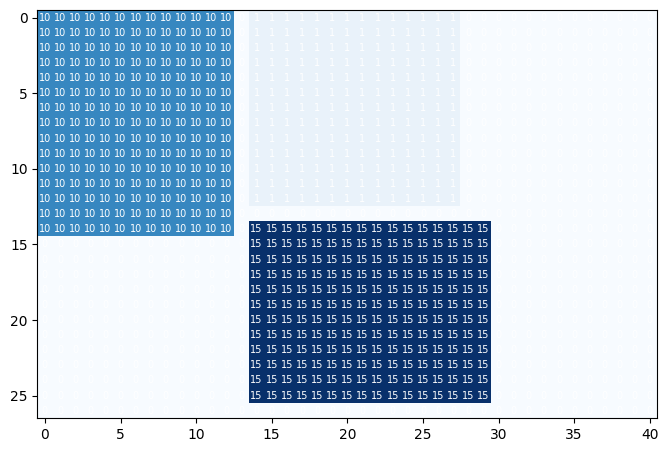

array([[10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       [10, 10, 10, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [111]:
draw_layout(레이아웃달력, "D2", 17)

2024-02-21 00:00:00


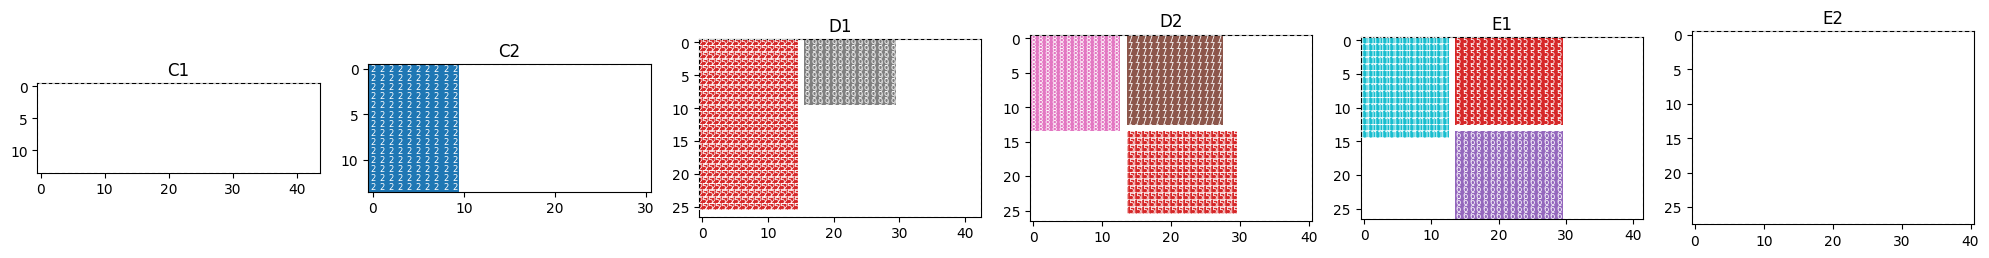

2024-02-26 00:00:00


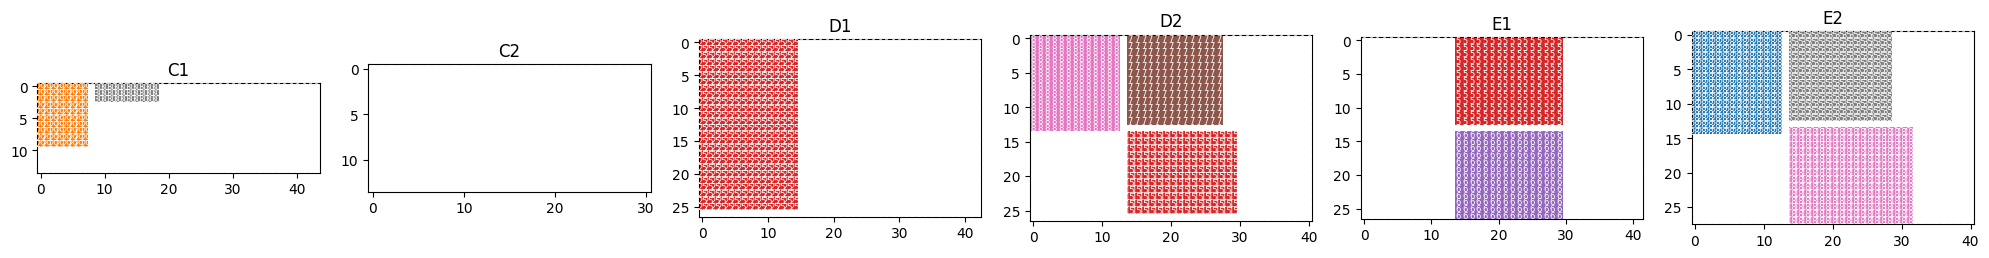

2024-03-02 00:00:00


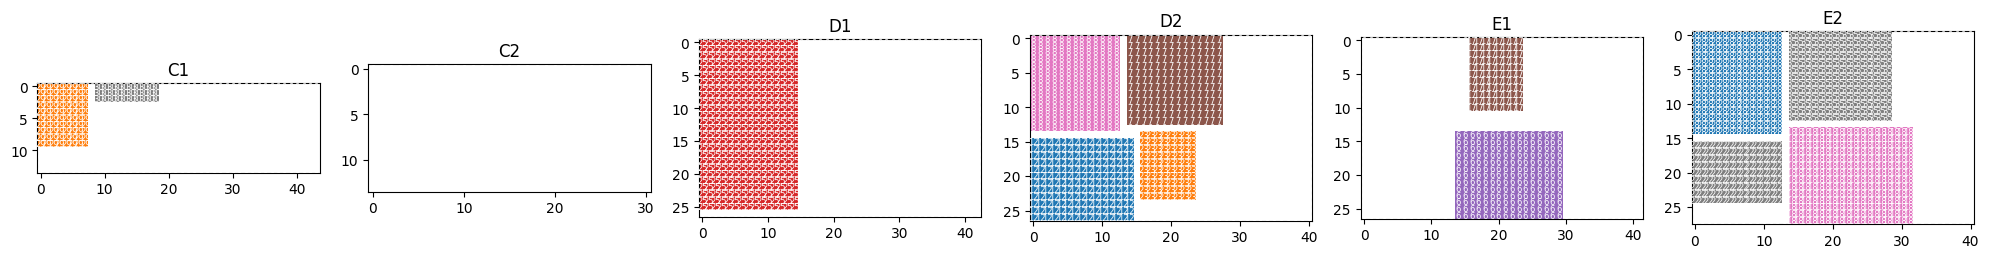

2024-03-07 00:00:00


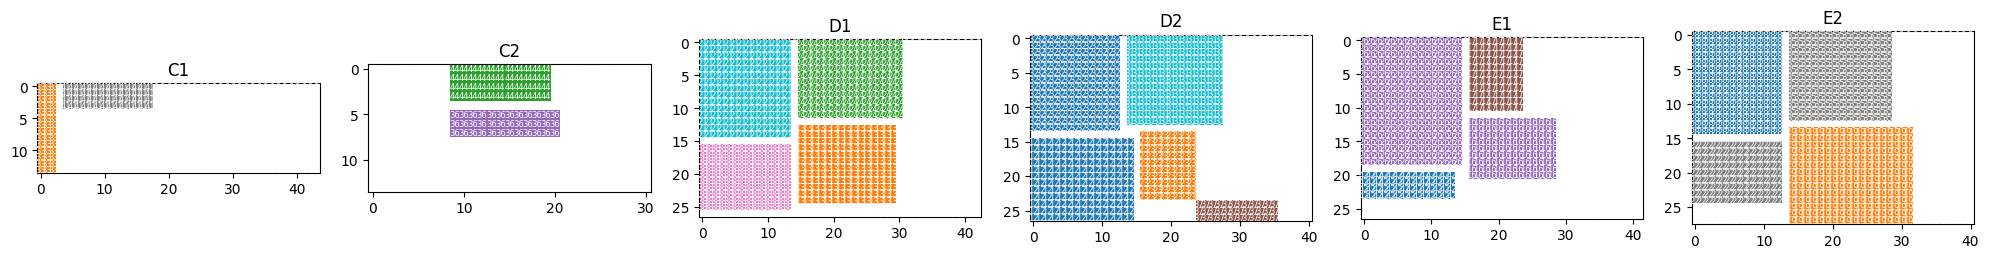

2024-03-12 00:00:00


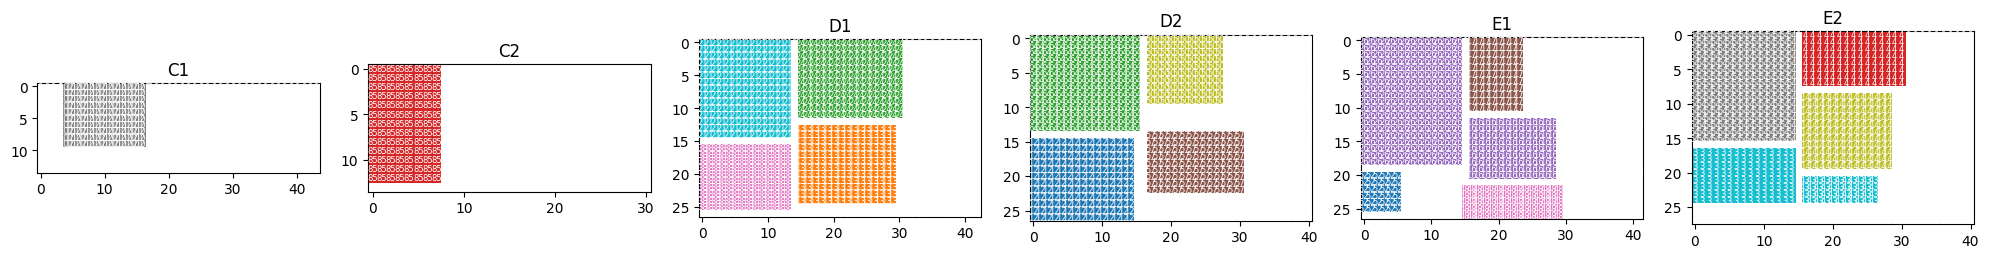

2024-03-17 00:00:00


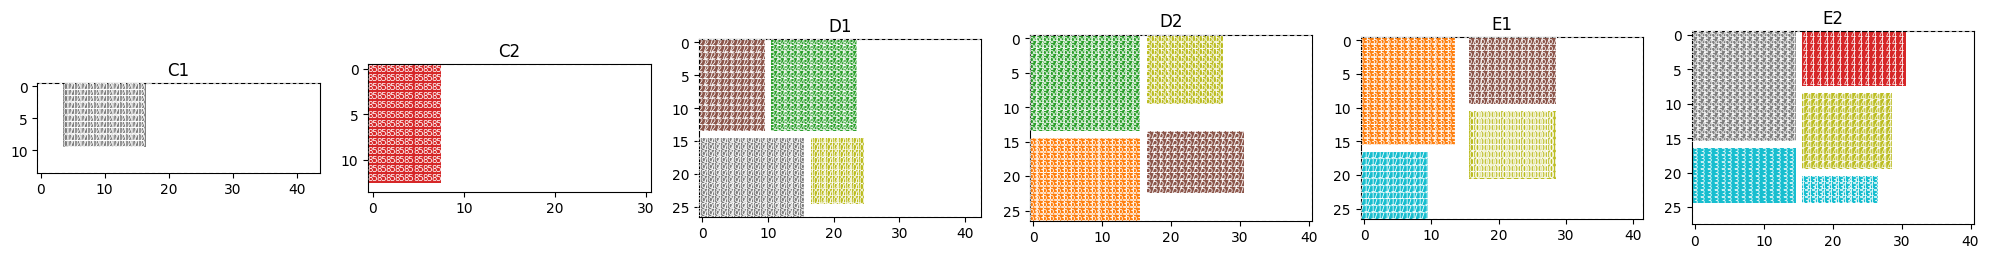

2024-03-22 00:00:00


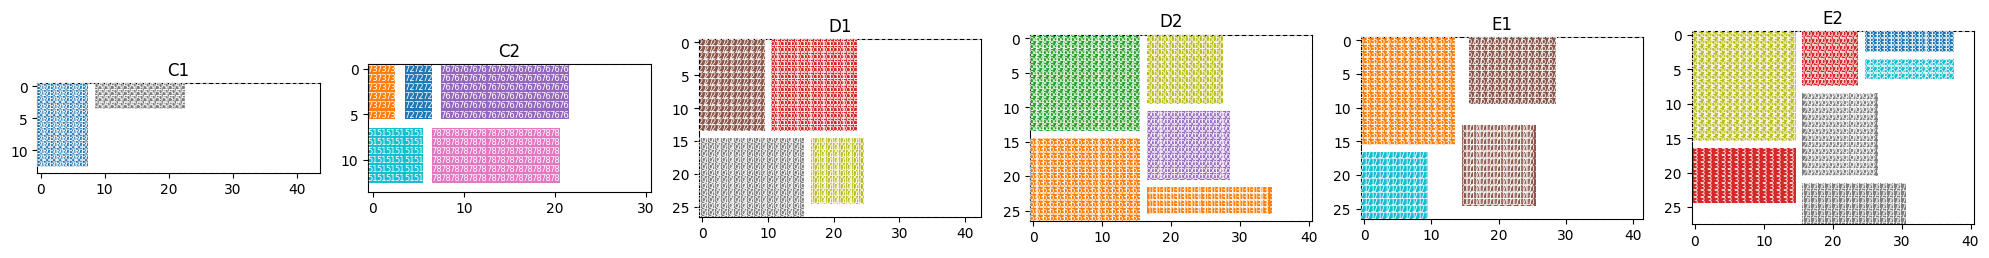

2024-03-27 00:00:00


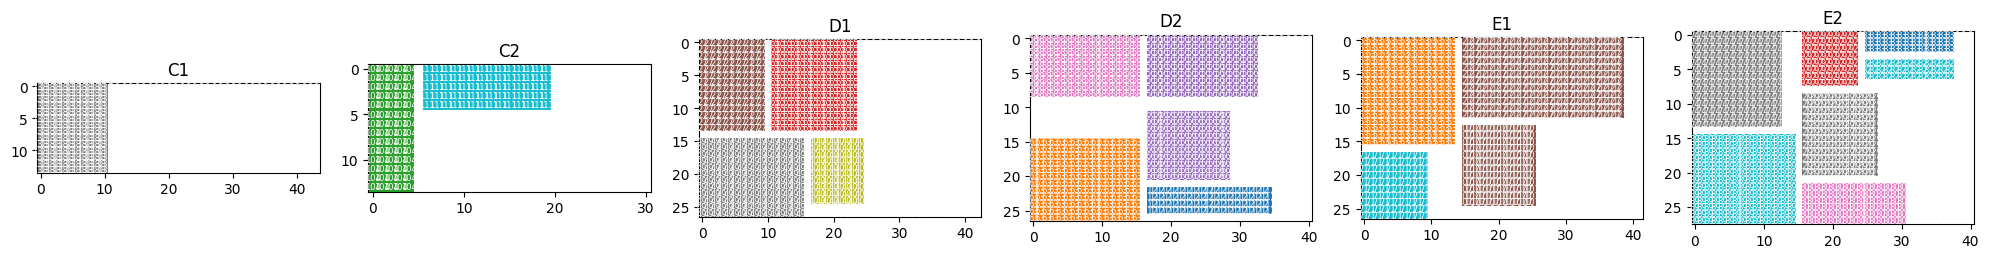

2024-04-01 00:00:00


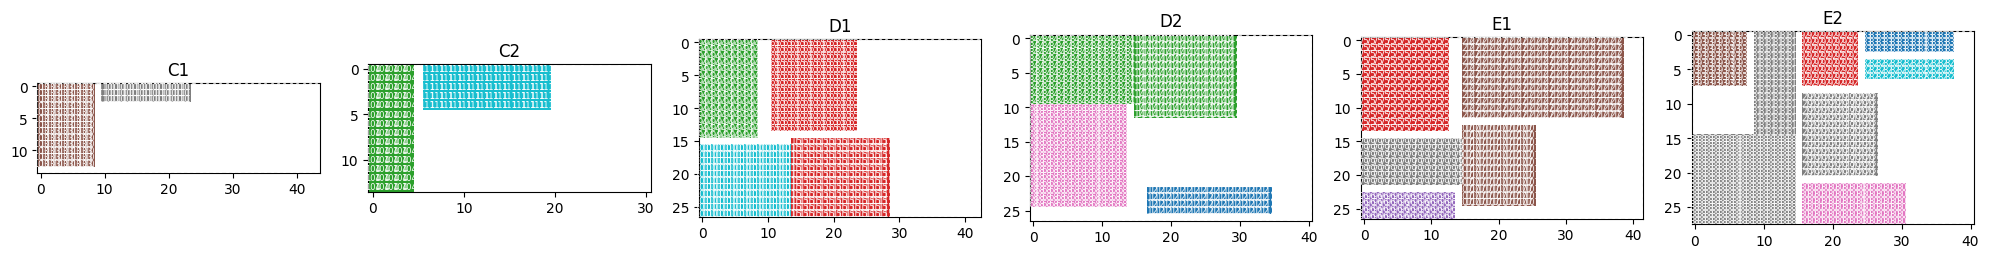

2024-04-06 00:00:00


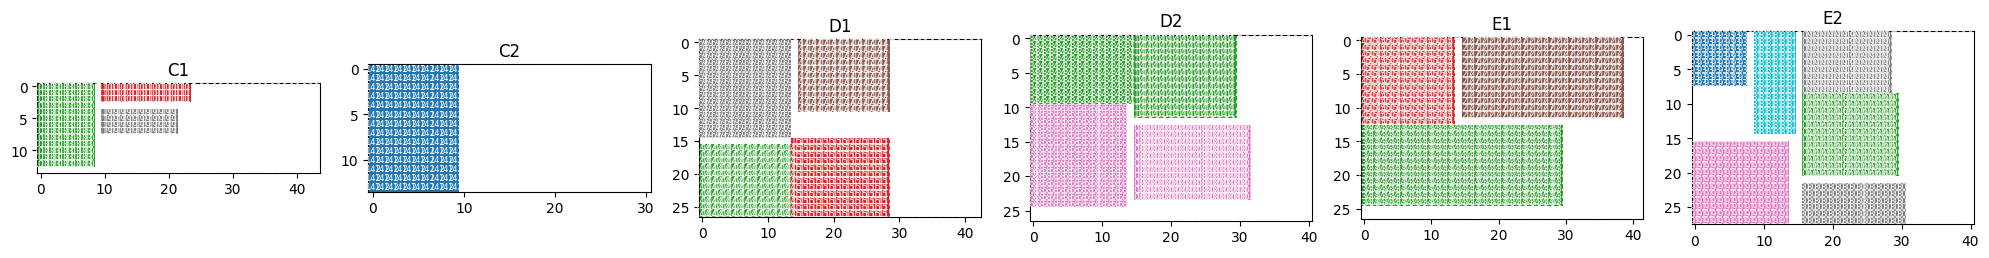

2024-04-11 00:00:00


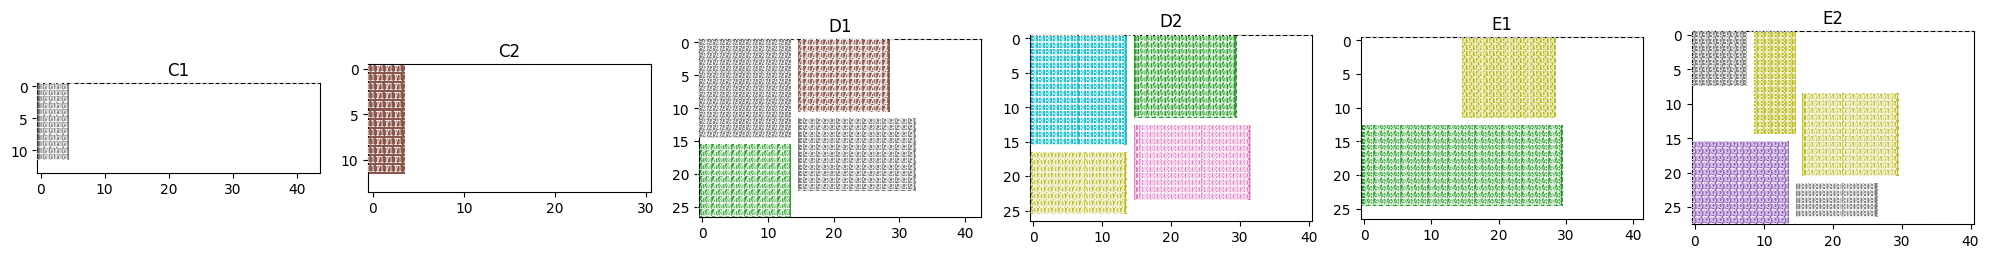

2024-04-16 00:00:00


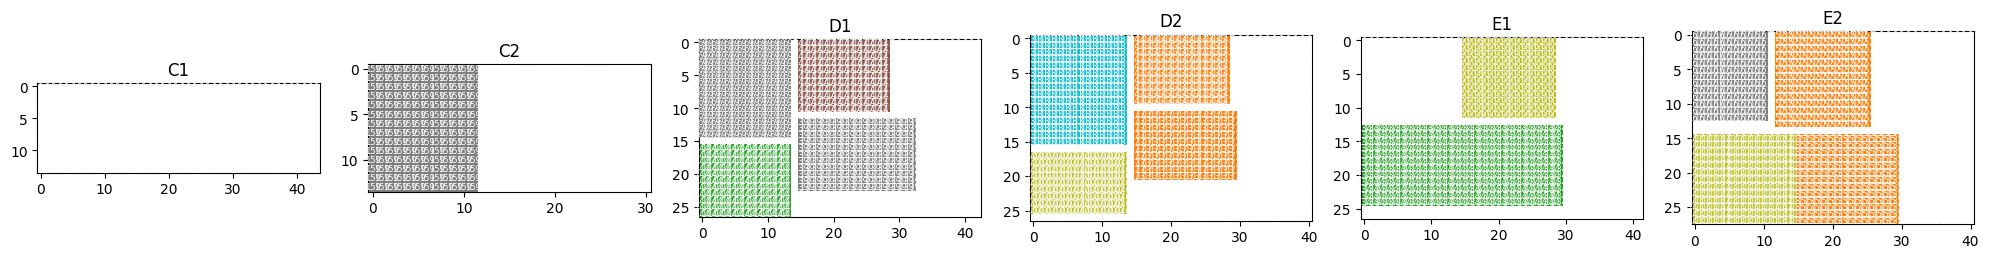

In [112]:
정반리스트 = 레이아웃달력.columns
for idx in range(17,80):
    if idx % 5 == 0:
        draw_layout_6_subplots(레이아웃달력, 정반리스트, idx)
    else:
        pass